In [12]:
import os
import shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [13]:
merged_data = pd.read_csv('merged_knn_imputed_filtered_data_phq.csv')
merged_data = merged_data.drop(columns='Unnamed: 0')

In [14]:
# make sure no na at this point
merged_data.isna().any().any()

np.False_

In [15]:
# split into our feature and target variables
phq = merged_data['phq4_EMA']
anx_phq = merged_data['phq4_anxiety_EMA']
dep_phq = merged_data['phq4_depression_EMA']
merged_data = merged_data.drop(columns=['phq4_EMA', 'phq4_anxiety_EMA', 'phq4_depression_EMA'])
merged_data_no_bfi = merged_data.drop(columns=['BFI10_extroversion_PRE', 'BFI10_agreeableness_PRE', 'BFI10_conscientiousness_PRE', 'BFI10_neuroticism_PRE', 'BFI10_openness_PRE'])

In [16]:
best_params = {
    'phq_with_bfi': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 40},
    'phq_no_bfi': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 35},
    'anxiety_phq_with_bfi': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 35},
    'anxiety_phq_no_bfi': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40},
    'depression_phq_with_bfi': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40},
    'depression_phq_no_bfi': {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 40},
}

In [17]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
datasets = {}
for target in [(phq, 'phq'), (anx_phq, 'anxiety_phq'), (dep_phq, 'depression_phq' )]:
    for dataset in [(merged_data, 'with_bfi'), (merged_data_no_bfi, 'no_bfi')]:
        print(target[1]+'_'+dataset[1])
        gamma_model = sm.GLM(target[0], dataset[0])
        gamma_results = gamma_model.fit()
        p_values = gamma_results.pvalues
        significant_columns = p_values[p_values < 0.5].index
        sig_dataset = dataset[0][significant_columns]
        
        datasets[target[1]+'_'+dataset[1]] = (sig_dataset, target[0])
        
    df1 = 0
    ddf2 = 0
    targ = 'phq'
    if len(list(datasets.keys()))==2:
        df1 = datasets['phq_with_bfi'][0]
        df2 = datasets['phq_no_bfi'][0]
    elif len(list(datasets.keys()))==4:
        df1 = datasets['anxiety_phq_with_bfi'][0]
        df2 = datasets['anxiety_phq_no_bfi'][0]
        targ = 'anxiety_phq'
    elif len(list(datasets.keys()))==6:
        df1 = datasets['depression_phq_with_bfi'][0]
        df2 = datasets['depression_phq_no_bfi'][0]
        targ = 'depression_phq'
    else:
        print('error')

    columns_in_df1_not_in_df2 = set(df1.columns) - set(df2.columns)
    columns_in_df2_not_in_df1 = set(df2.columns) - set(df1.columns)
    print("Columns only in with bfi for "+targ)
    for col in columns_in_df1_not_in_df2:
        print(f"  - {col}")
    print('---------')
    print("Columns only in w/out bfi for "+targ)
    for col in columns_in_df2_not_in_df1:
        print(f"  - {col}")

phq_with_bfi
phq_no_bfi
Columns only in with bfi for phq
  - f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain_norm:14dhist
  - f_blue:phone_bluetooth_doryab_stdscansall_norm:14dhist
  - f_call:phone_calls_rapids_missed_timefirstcall_norm:14dhist
  - f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain_norm:14dhist
  - f_call:phone_calls_rapids_outgoing_meanduration_norm:14dhist
  - BFI10_openness_PRE
  - BFI10_agreeableness_PRE
  - f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain_norm:14dhist
  - f_screen:phone_screen_rapids_firstuseafter00unlock_norm:14dhist
  - BFI10_conscientiousness_PRE
  - f_slp:fitbit_sleep_summary_rapids_avgdurationawakemain_norm:14dhist
  - BFI10_extroversion_PRE
  - f_steps:fitbit_steps_intraday_rapids_stdsteps_norm:14dhist
  - f_slp:fitbit_sleep_intraday_rapids_stddurationasleepunifiedmain_norm:14dhist
  - f_loc:phone_locations_barnett_disttravelled_norm:14dhist
  - f_screen:phone_screen_rapids_sumdurationunlock_locmap_home_norm:14dhis

phq_with_bfi
Cross_val scores: [-5.19194053 -4.88160626 -5.24062104 -5.00326717 -5.57061368]


100%|===================| 5241/5257 [01:09<00:00]        

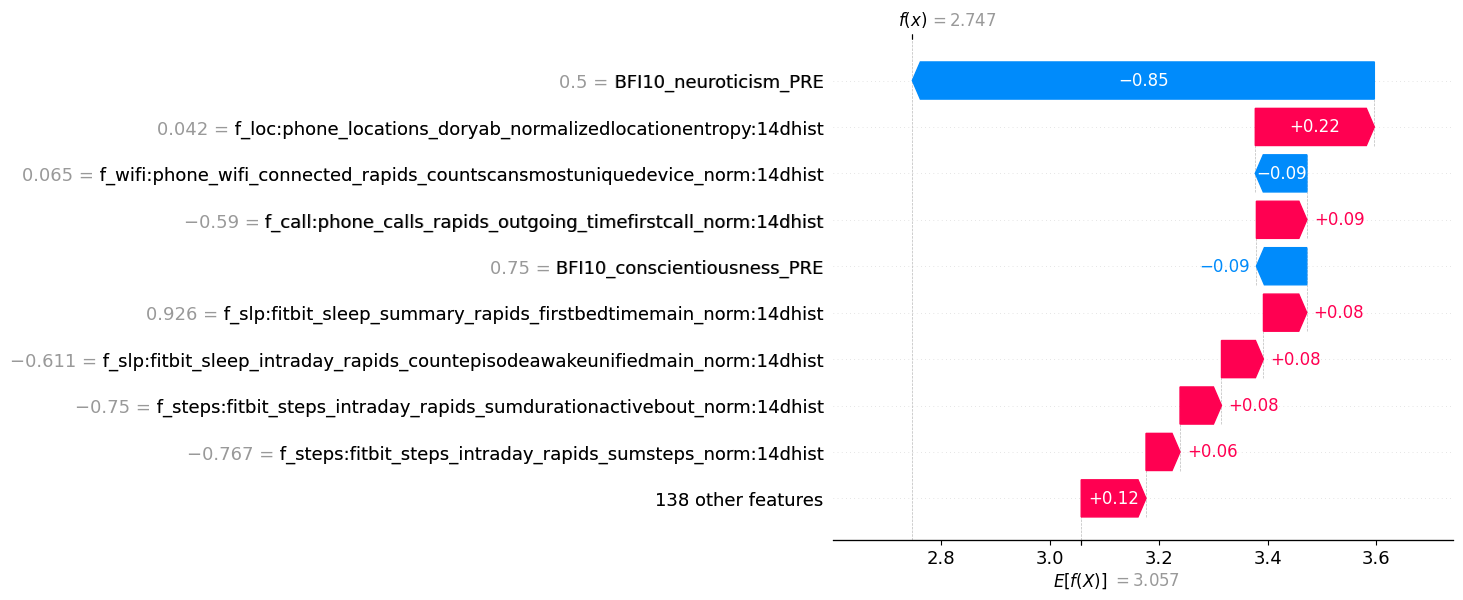

phq_no_bfi
Cross_val scores: [-6.33028483 -6.19611092 -6.46169883 -6.24591349 -6.67001294]


100%|===================| 5251/5257 [01:11<00:00]        

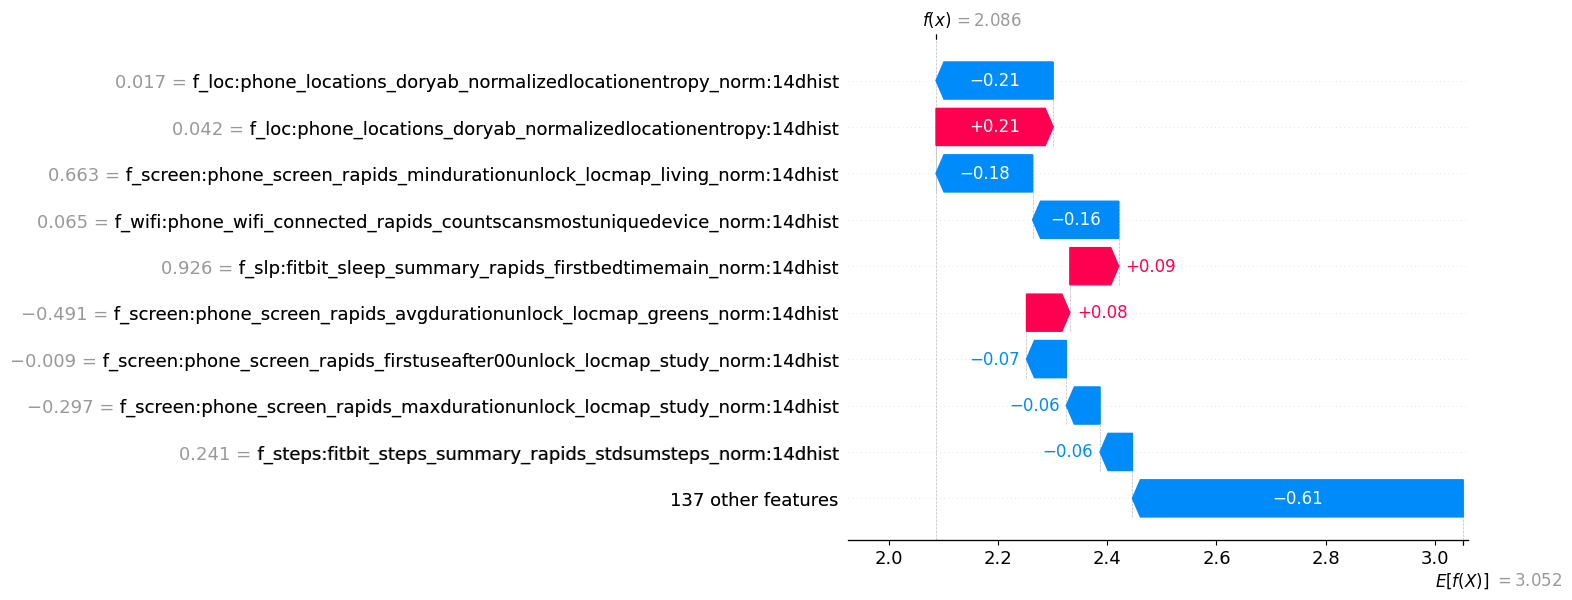

anxiety_phq_with_bfi
Cross_val scores: [-1.75565524 -1.56335208 -1.71967527 -1.60139258 -1.77651855]


100%|===================| 5239/5257 [00:55<00:00]        

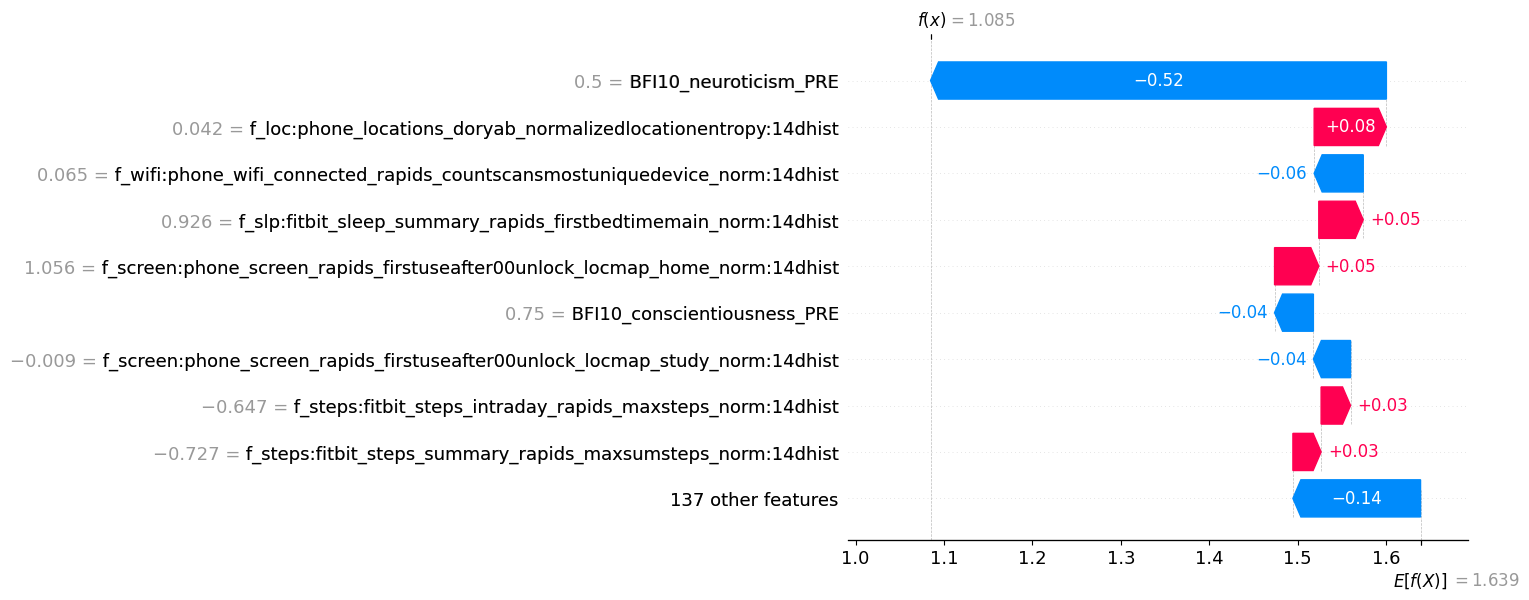

anxiety_phq_no_bfi
Cross_val scores: [-2.03480623 -1.86426174 -2.04219189 -1.94267595 -2.08997682]


 99%|===================| 5230/5257 [01:11<00:00]        

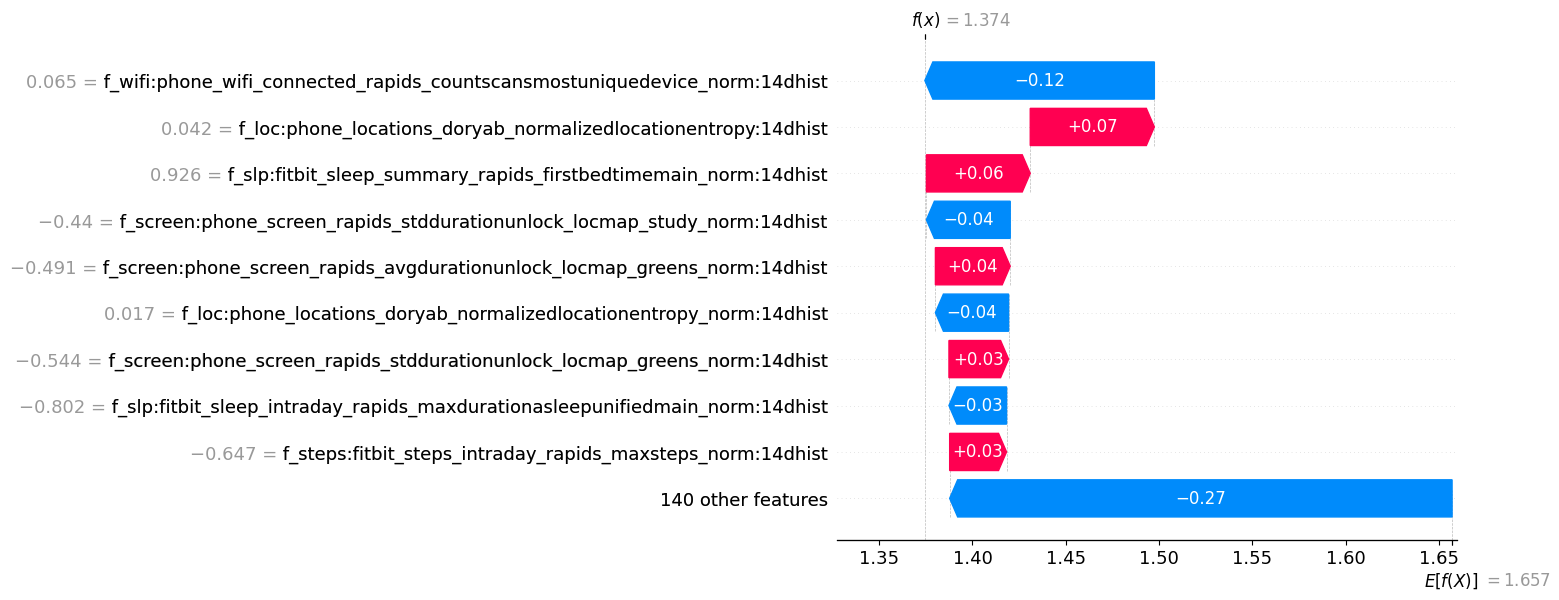

depression_phq_with_bfi
Cross_val scores: [-1.6308285  -1.55804591 -1.54592784 -1.61079156 -1.5545544 ]


 99%|===================| 5222/5257 [01:05<00:00]        

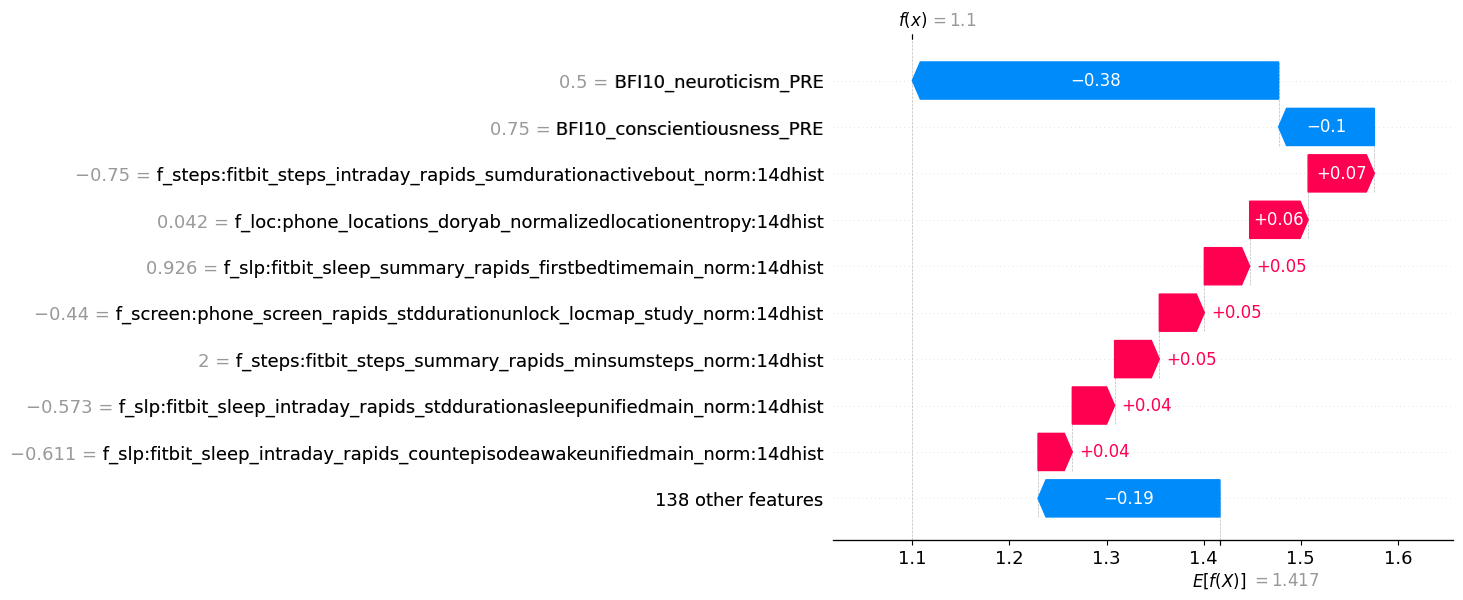

depression_phq_no_bfi
Cross_val scores: [-1.87302266 -1.91474073 -1.7897798  -1.8678125  -1.93210496]


 99%|===================| 5180/5257 [01:01<00:00]        

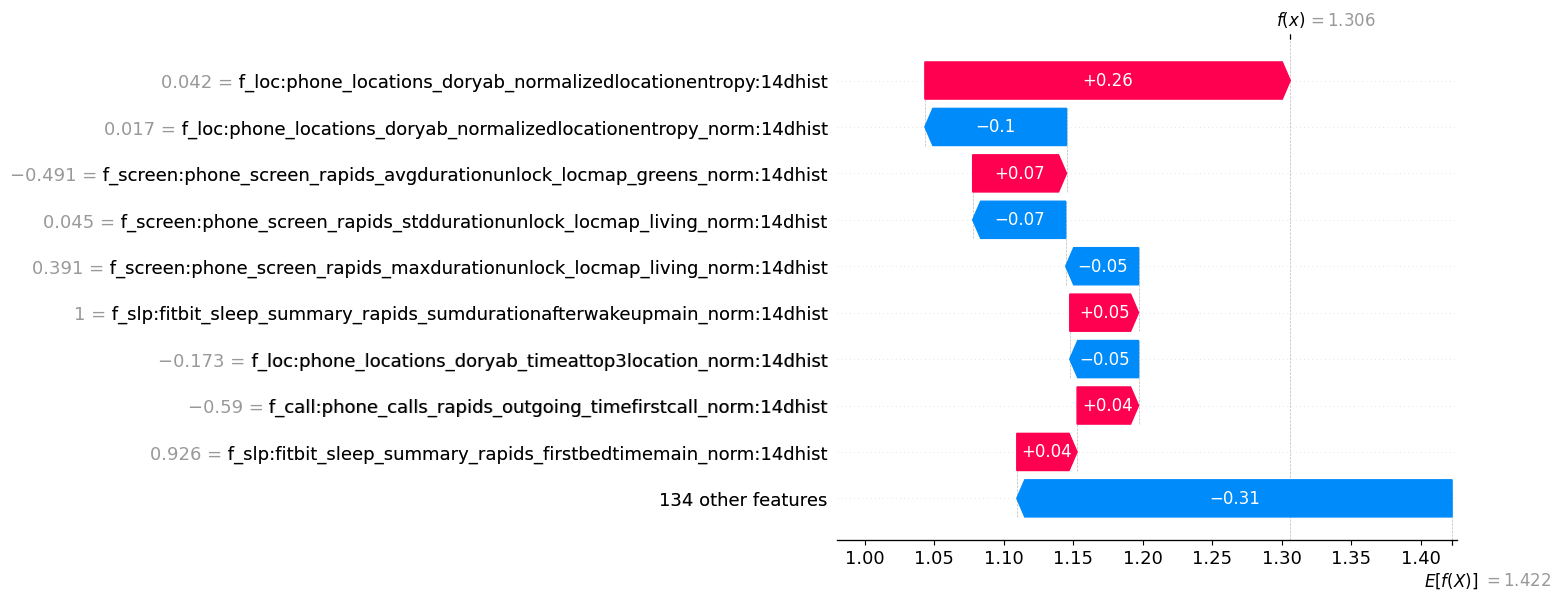

In [8]:
for key in datasets:
    print(key)
    params = best_params[key]
    dataset = datasets[key][0]
    target = datasets[key][1]
    
    rf = RandomForestRegressor(**params)
    rf.fit(dataset, target)
    cv_scores = cross_val_score(
        rf, 
        dataset, 
        target, 
        cv=kf, 
        scoring=mse_scorer
    )
    print(f'Cross_val scores: {cv_scores}')
    explainer = shap.TreeExplainer(rf, data=dataset, feature_names=dataset.columns)
    shap_values = explainer(dataset, check_additivity=False)
    shap.plots.waterfall(shap_values[0])